In [1]:
!pip install yfinance
!pip install yahooquery
!pip install tvdatafeed
!pip install tensorflow
!pip install https://github.com/matplotlib/mpl_finance/archive/master.zip
!pip install cairocffi
from tvDatafeed import TvDatafeed, Interval
from yahooquery import Screener
import yfinance as yf   
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
import random 
from tensorflow.keras.models import load_model
import os
import shutil
import mplfinance as mpl 
from datetime import datetime
import glob
from PIL import Image
import cv2
%matplotlib notebook
import gc
import matplotlib.pyplot as plt
import matplotlib
matplotlib.use('cairo')
from keras.models import Sequential
from keras.layers import Conv2D,MaxPooling2D,Activation,Dropout,Flatten,Dense,AveragePooling2D,GlobalAveragePooling2D
%matplotlib inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached https://github.com/matplotlib/mpl_finance/archive/master.zip
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [2]:
!pip install finplot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [3]:
from mpl_finance import candlestick_ohlc

In [22]:
import finplot as fplt
import matplotlib.dates as mpl_dates


In [77]:
def work_with_dir():
  if os.path.exists("/content/data/"):
    shutil.rmtree("/content/data/", ignore_errors=True)
    print("Data Folder Removed")
    os.mkdir("/content/data/")
  if not os.path.exists("/content/data/"):
    os.mkdir("/content/data/")
  if not os.path.exists("/content/extracted/"):
    os.mkdir("/content/extracted/")
  if not os.path.exists("/content/checkpoints/"):
    os.mkdir("/content/checkpoints/")

def get_crypto_syms():
   # 'all_cryptocurrencies_au','all_cryptocurrencies_ca','all_cryptocurrencies_eu','all_cryptocurrencies_gb','all_cryptocurrencies_in',
   screens = [
       'all_cryptocurrencies_us', 'all_cryptocurrencies_au', 'all_cryptocurrencies_ca', 'all_cryptocurrencies_eu', 'all_cryptocurrencies_gb', 'all_cryptocurrencies_in', ]
   s = Screener()
   symbols = []
   for i in screens:
      data = s.get_screeners(i, count=250)
      dicts = data[i]['quotes']
      syms = [d['symbol'] for d in dicts]
      for sym in syms:
        symbols.append(sym)
   # print(len(symbols))
   # pieces = 15
   # new_arrays = np.array_split(symbols, pieces)
   return symbols

def download_data(symbols, periodd, intervall):
  indexx = 100
  work_with_dir()
  for symbol in symbols:
    if ((symbols.index(symbol)+1) % 100 == 0):
      print(f" -- {indexx}", end="")
      indexx = indexx + 100
    try:
        data = yf.download(symbol, period=periodd,
                           interval=intervall, progress=False, show_errors=False)
        if data.empty:
           pass
        else:
            data.to_csv(f"/content/data/{symbol}.csv")
    except:
       print("Error!")
  print(" ")

def extract_data(how_many_future_candles, how_many_past_candles, each_row_past):
  print(f"Files In Data : {len(os.listdir('/content/data/'))}")
  pd.options.mode.chained_assignment = None
  files = os.listdir("/content/data/")
  print("Processing File:")
  now = datetime.now().strftime("%H%M%S")
  os.mkdir(f"/content/extracted/{now}/")
  index = 1
  for file in files:
     print(f"File Number {index}:", end=" ")
     each_file_proc(file, now, how_many_future_candles,
                    how_many_past_candles, each_row_past)
     index = index + 1
  print(" ")
  return now

def each_file_proc(file, now, how_many_future_candles, how_many_past_candles, each_row_past):

    address = f"/content/data/{file}"
    data = pd.read_csv(address)

    if len(data.columns) == 7:
      data = data.iloc[:, 1:]


    ohlc = data.loc[:, ['Open', 'High', 'Low', 'Close']]
    date_list = []
    rrng = np.array(ohlc).shape[0]
    for i in range(rrng):
            date_list.append(datetime.fromordinal(
                datetime.today().toordinal()+i).strftime('%Y-%m-%d'))
    ohlc.index = date_list        
    ohlc.index = pd.to_datetime(ohlc.index)
    ohlc.index.name = "Date"
    ohlc["Date"] = date_list
    ohlc['Date'] = pd.to_datetime(ohlc['Date'])
    ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)
    max_index = data.shape[0]-which_future_or_past
    ohlc = ohlc.astype(float)
    ohlc['Date'] = ohlc['Date'].apply(mpl_dates.num2date)
    # re-order columns order to Date, Open, High, Low, Close
    ohlc = ohlc[['Date', 'Open', 'High', 'Low', 'Close']]
    ohlc['Date'] = ohlc['Date'].apply(mpl_dates.date2num)

    for i in range(each_row_past,max_index):

        rows = ohlc.iloc[i-each_row_past:i, :]
        past_candles = []
        for z in range(1, how_many_past_candles+1):
          past_candles.append((data.iloc[i-z,-1]+data.iloc[i-z,0])/2)
        past_candles = sum(past_candles)/len(past_candles)
        next_candles = []
        for z in range(0, how_many_future_candles):
          next_candles.append((data.iloc[i+z,-1]+data.iloc[i+z,0])/2)
        next_candles = sum(next_candles)/len(next_candles)
        if next_candles > past_candles:
          sugg = 1
        else:
          sugg = 0
        fig, ax = plt.subplots()
        ax.set_xlabel('')
        ax.set_ylabel('')
        right_now = datetime.now().strftime("%H%M%S%f")
        address = f"/content/extracted/{now}/{right_now}_{sugg}.png"
        

        candlestick_ohlc(ax, rows.values, colorup='green', colordown='red',)
        date_format = mpl_dates.DateFormatter('%d-%m-%Y')
        ax.xaxis.set_major_formatter(date_format)
        fig.autofmt_xdate()
        fig.tight_layout()
        fig.savefig(address)
        


        if i % 10 == 0:
            print(f"{i}/{max_index}", end=" ")
        if i % 20 == 0:
          fig.clear()

    plt.close(fig)
    print("")


def start(how_many_future_candles, how_many_past_candles, each_row_past):
    folder_name = extract_data(
        how_many_future_candles, how_many_past_candles, each_row_past)
    return folder_name

In [6]:
symbols = get_crypto_syms()
print(f"Symbols : {len(symbols)}")
symbols = ["btc-usd","eth-usd","trx-usd","ltc-usd","xrp-usd","bnb-usd"]
download_data(symbols,"50d","1d")

Symbols : 1500
Data Folder Removed
 


Files In Data : 6
Processing File:
File Number 1: 30/49 40/49 
File Number 2: 30/49 

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:107: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


40/49 
File Number 3: 30/49 40/49 
File Number 4: 30/49 40/49 
File Number 5: 30/49 40/49 
File Number 6: 30/49 40/49 
 


114

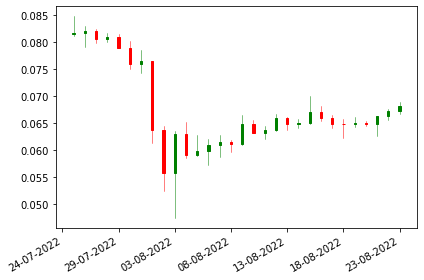

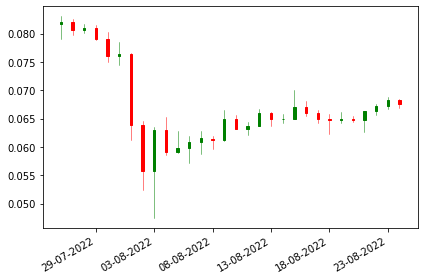

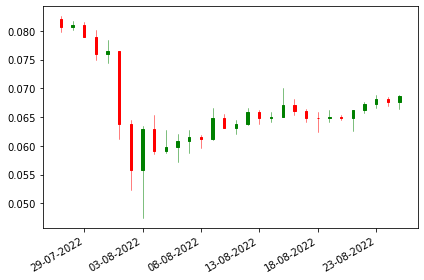

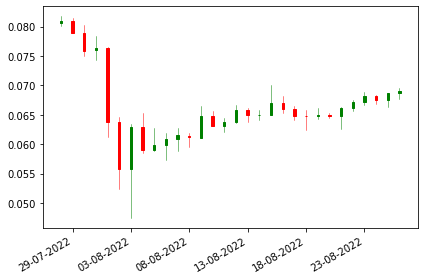

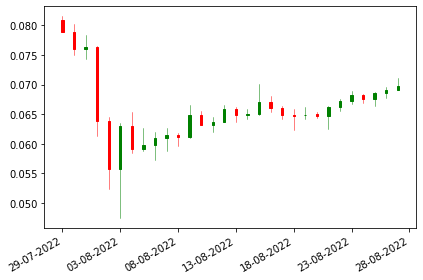

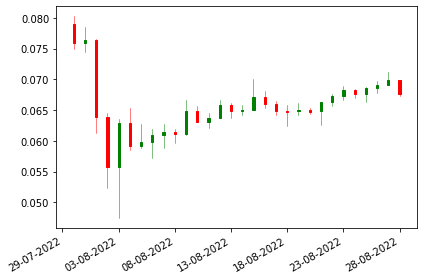

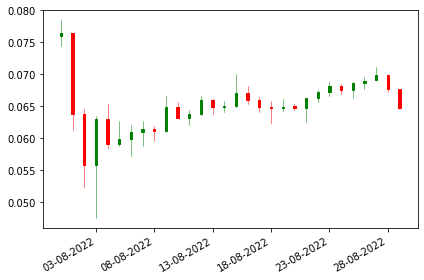

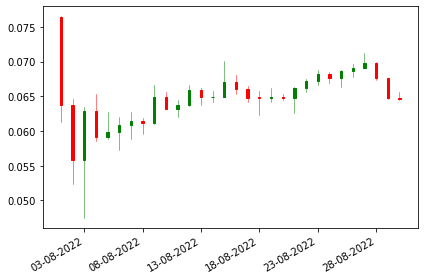

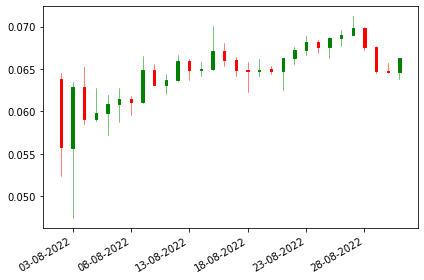

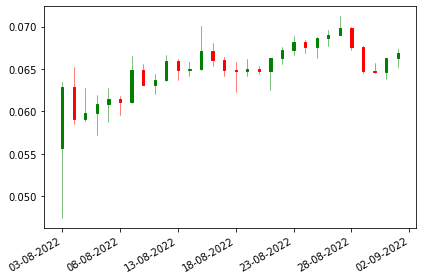

<Figure size 432x288 with 0 Axes>

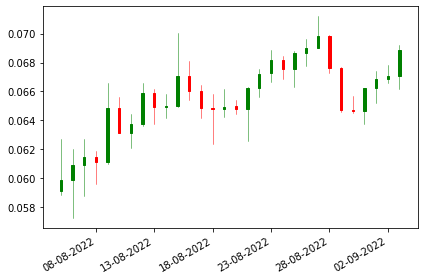

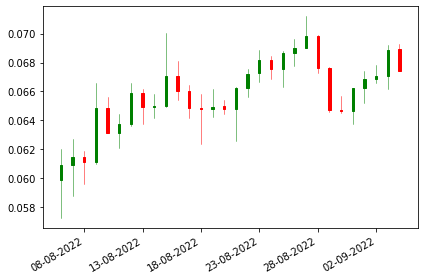

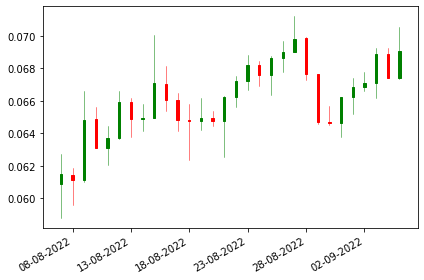

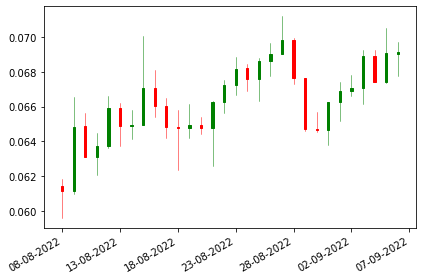

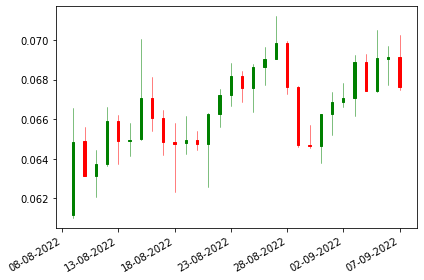

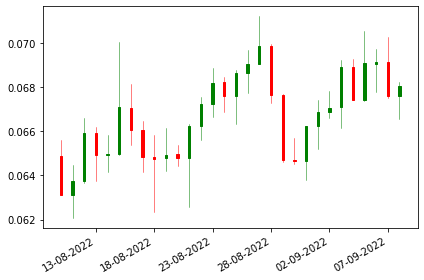

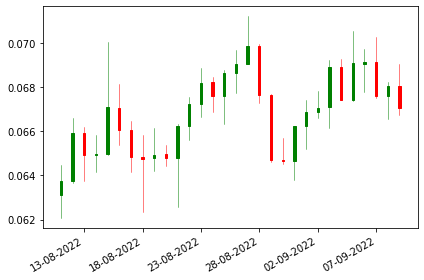

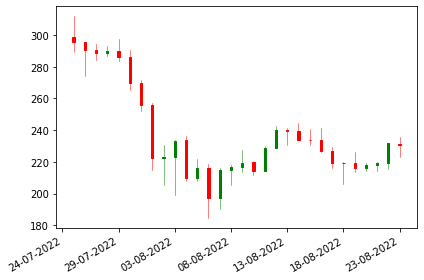

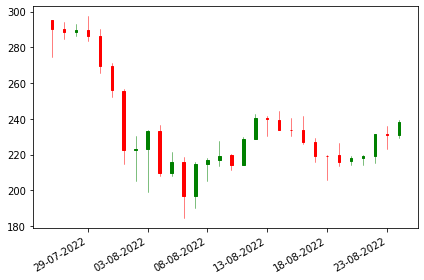

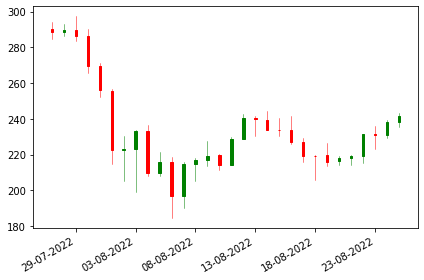

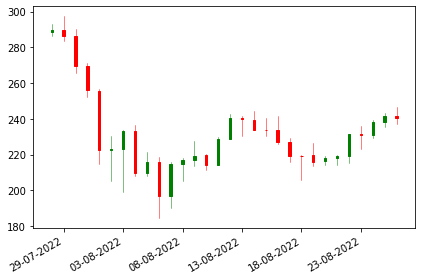

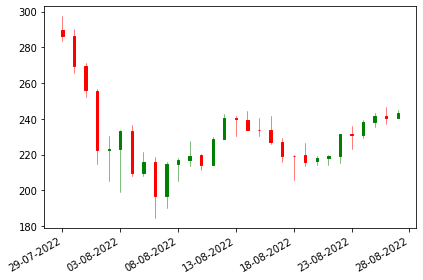

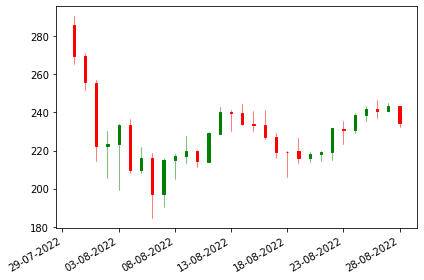

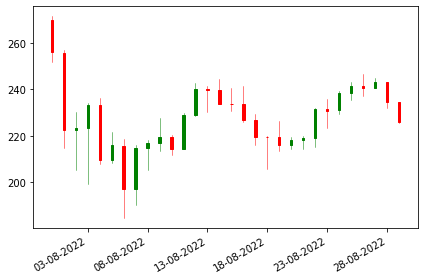

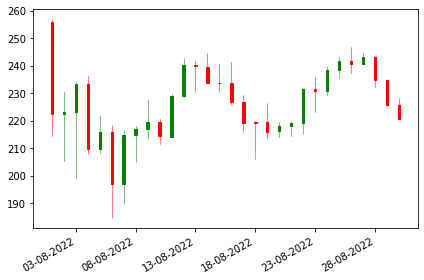

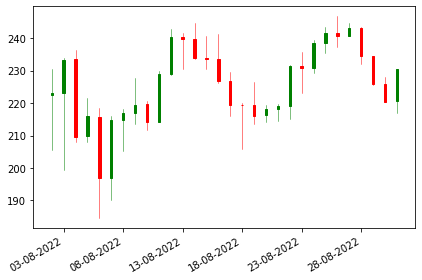

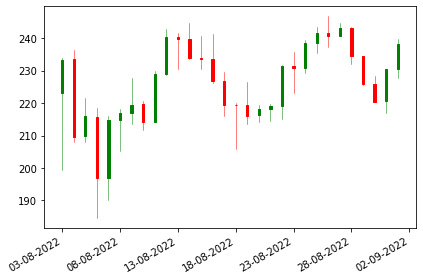

<Figure size 432x288 with 0 Axes>

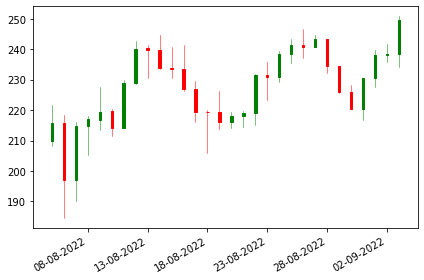

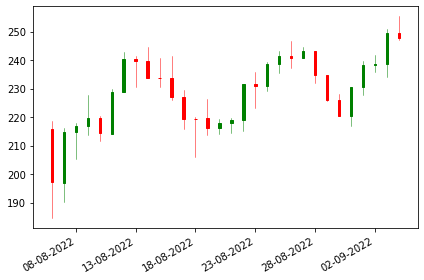

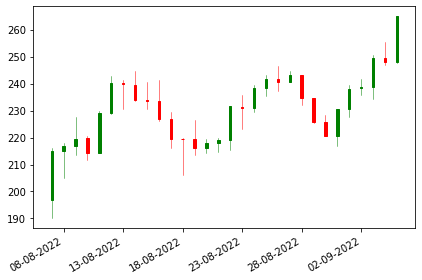

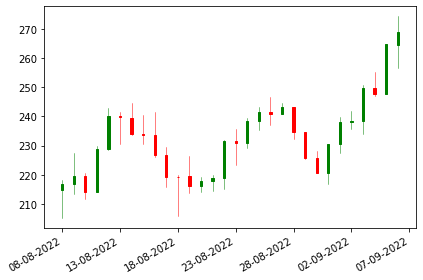

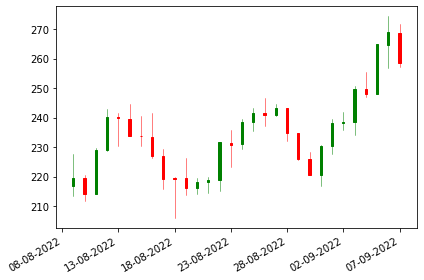

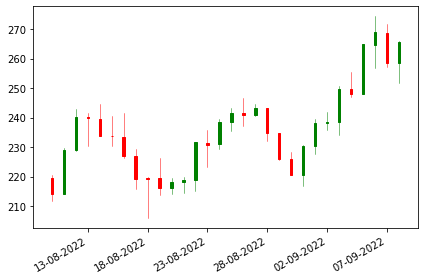

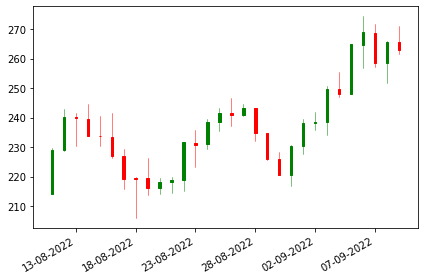

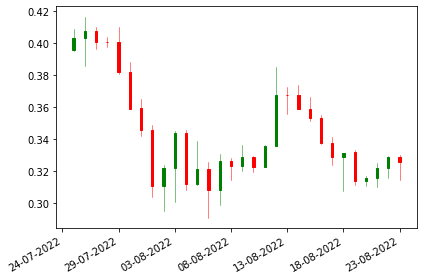

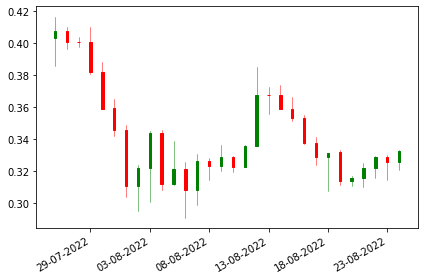

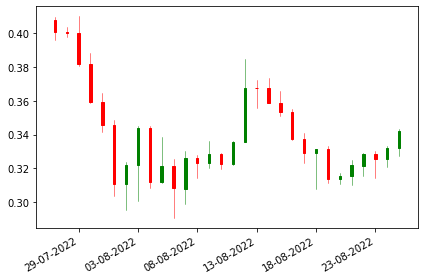

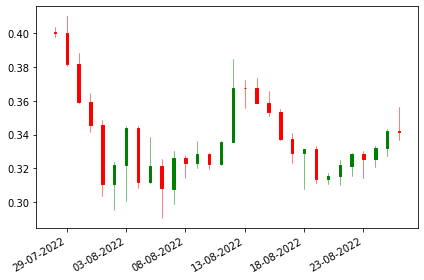

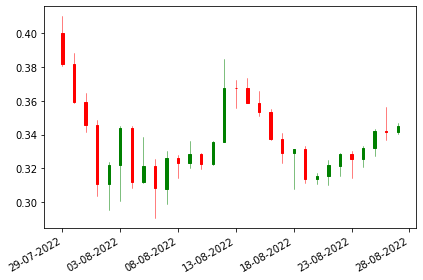

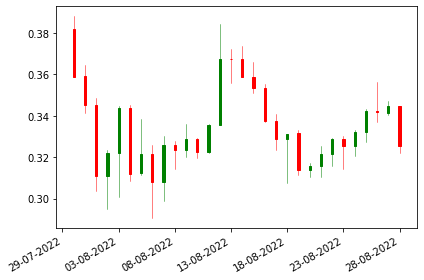

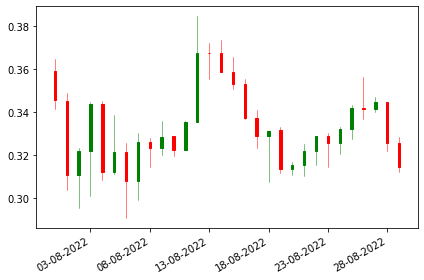

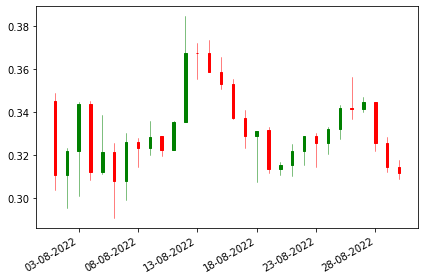

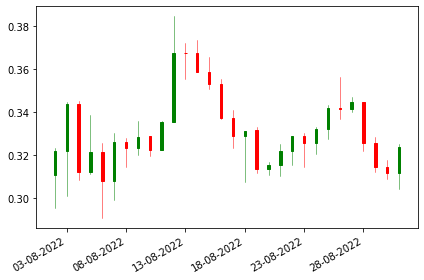

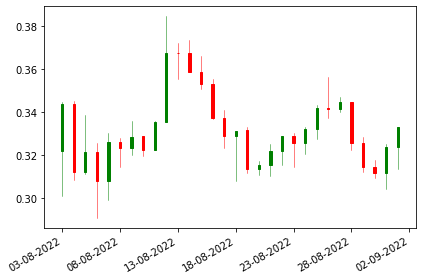

<Figure size 432x288 with 0 Axes>

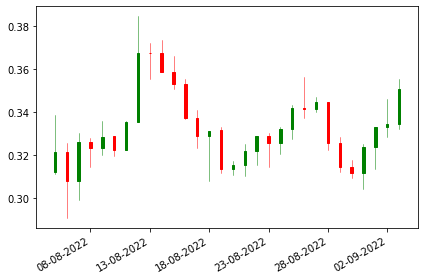

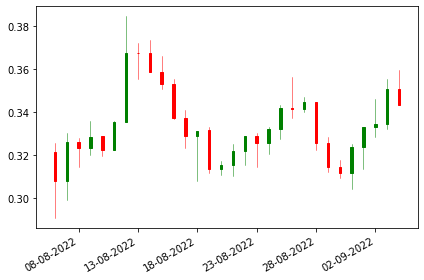

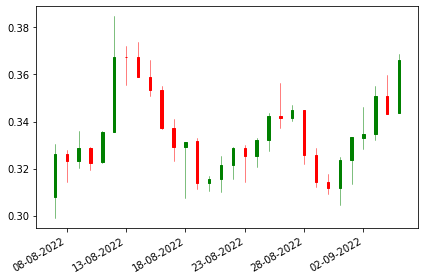

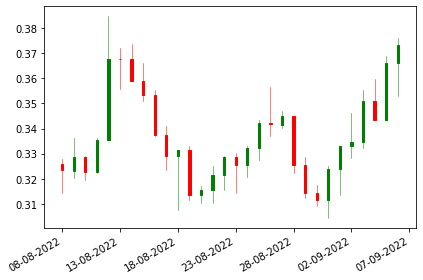

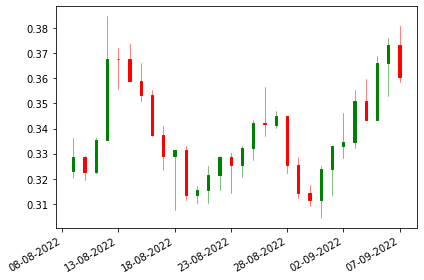

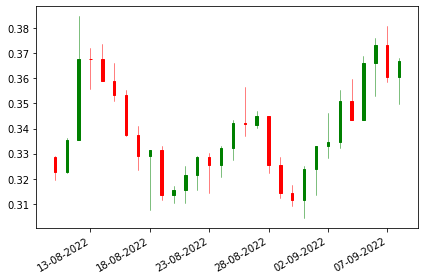

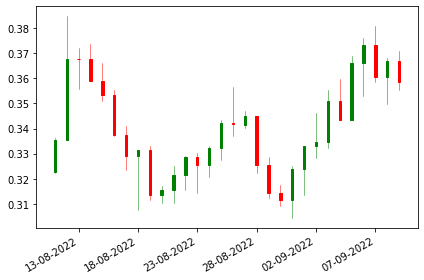

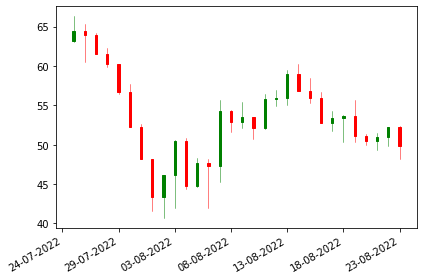

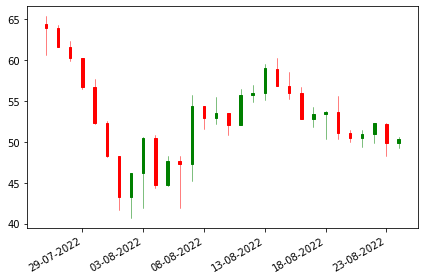

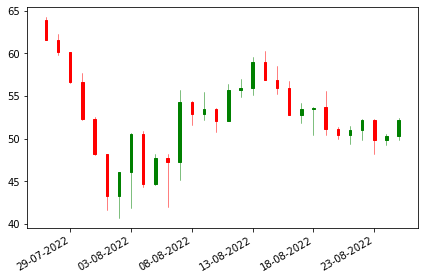

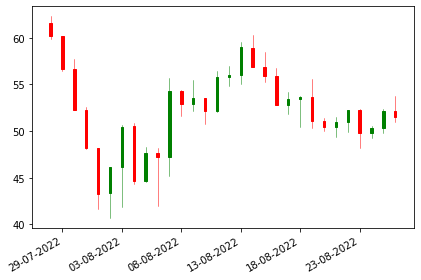

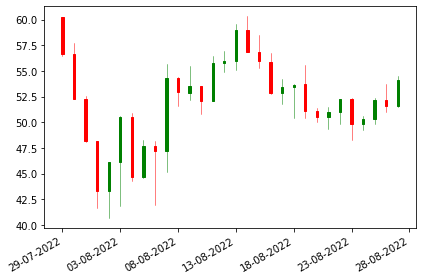

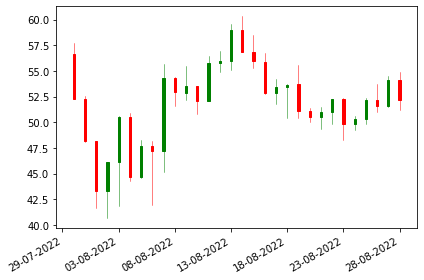

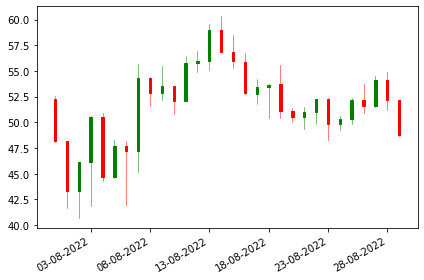

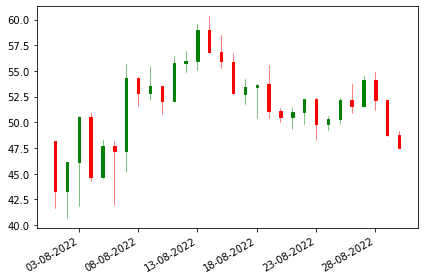

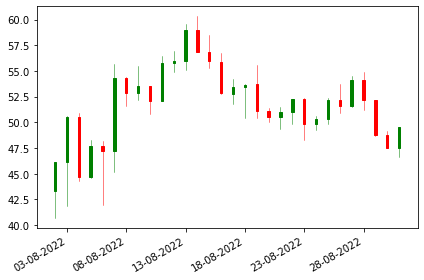

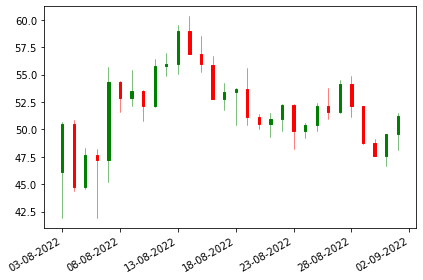

<Figure size 432x288 with 0 Axes>

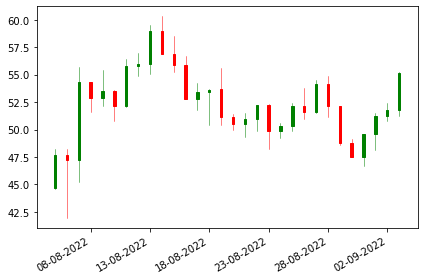

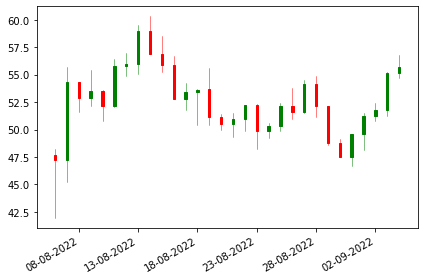

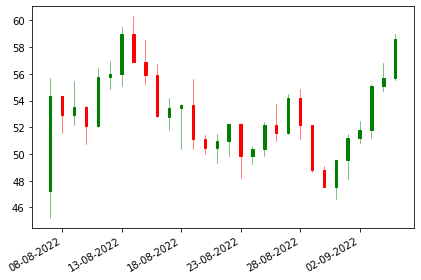

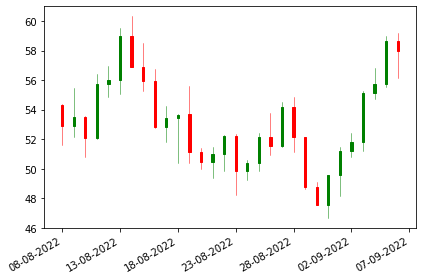

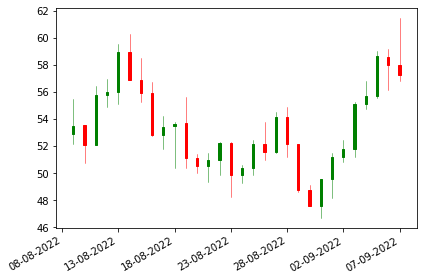

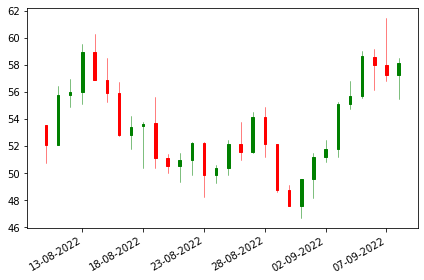

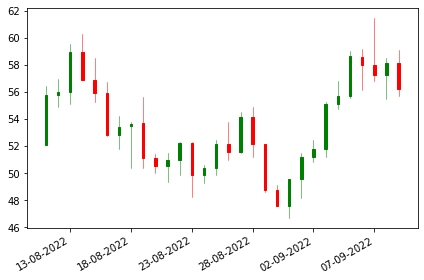

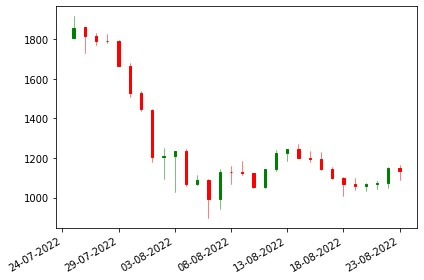

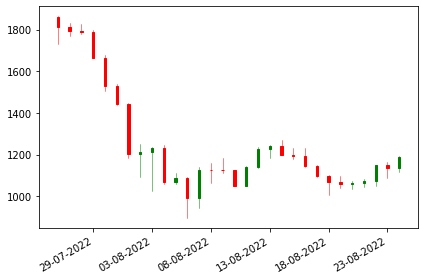

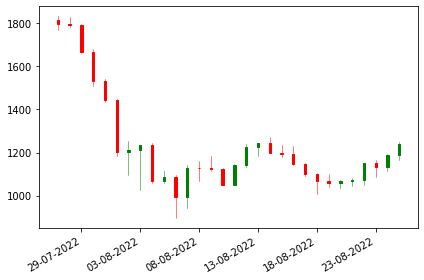

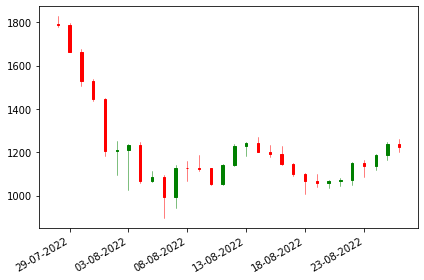

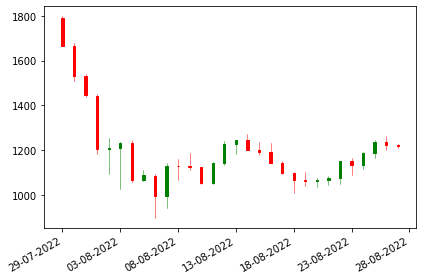

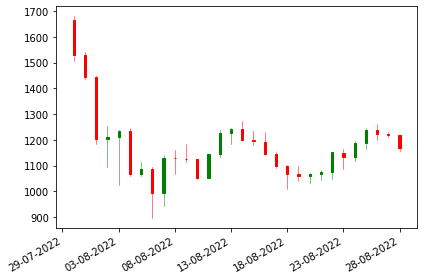

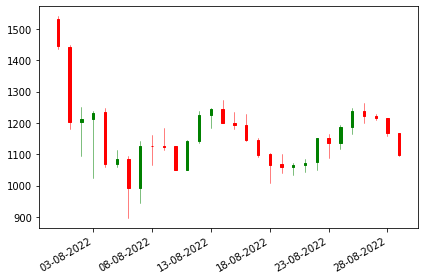

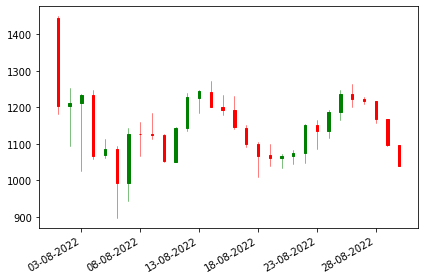

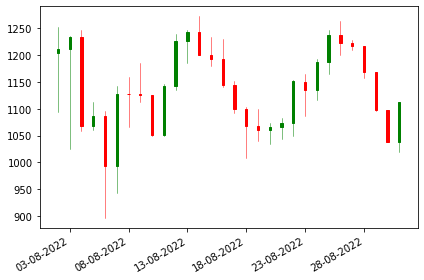

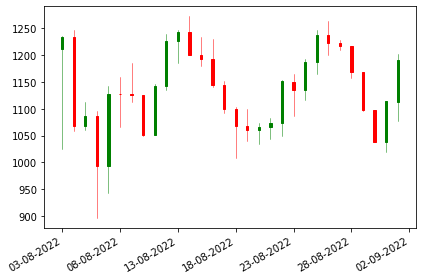

<Figure size 432x288 with 0 Axes>

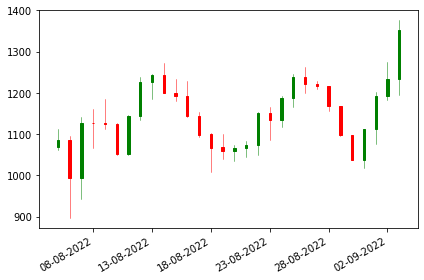

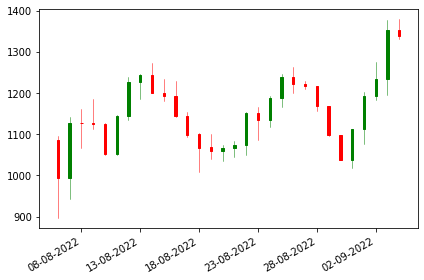

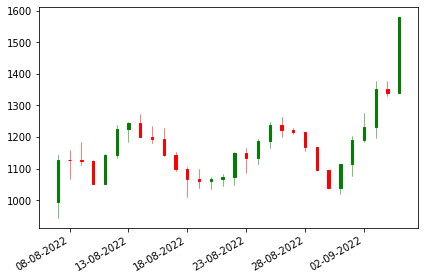

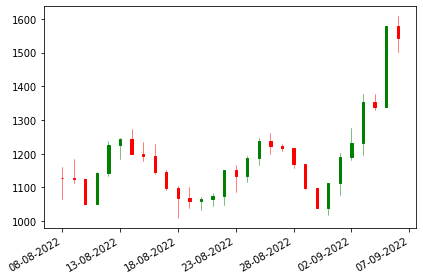

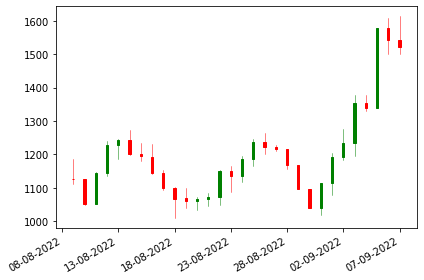

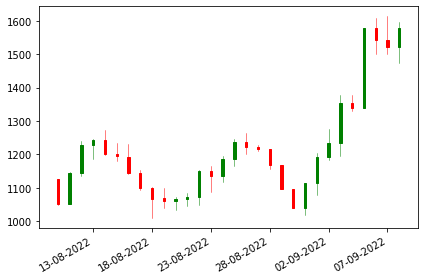

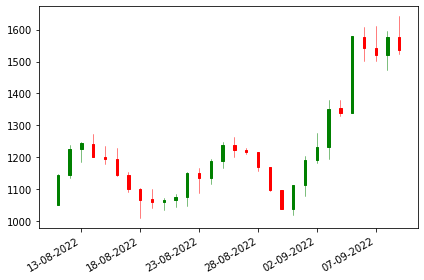

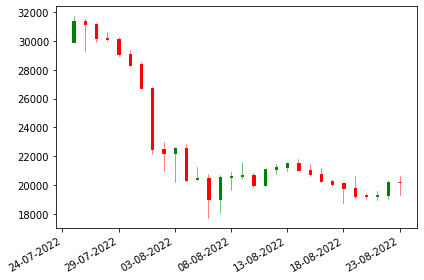

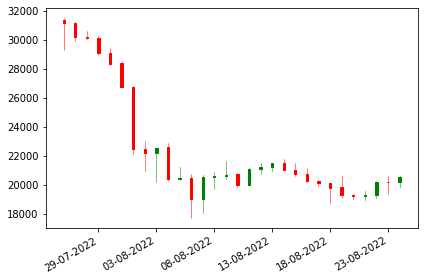

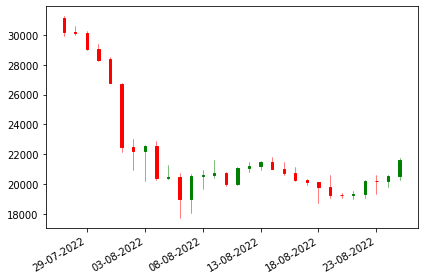

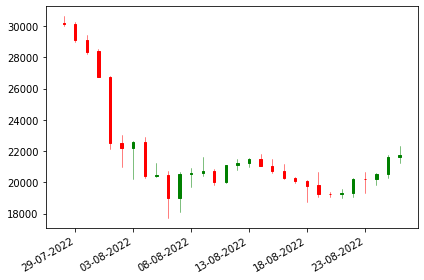

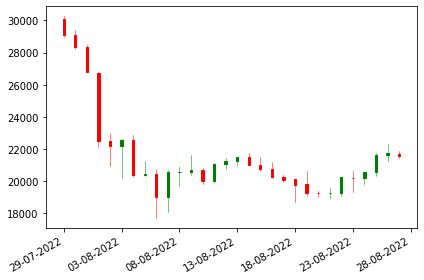

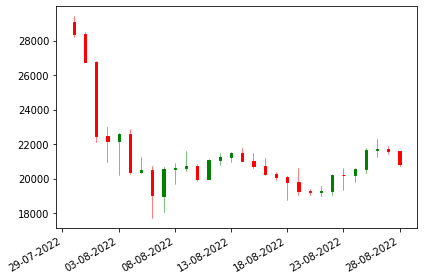

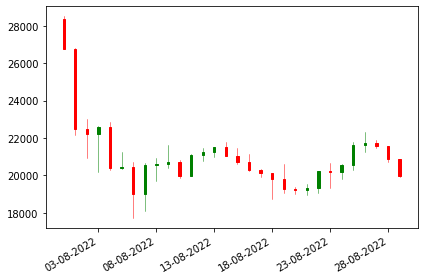

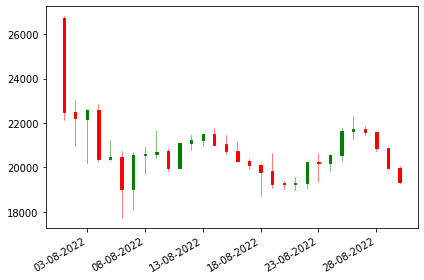

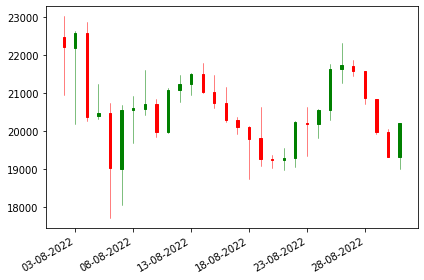

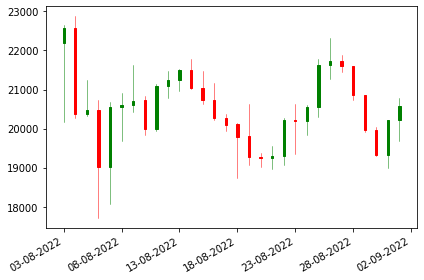

<Figure size 432x288 with 0 Axes>

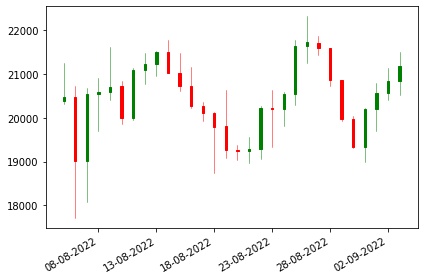

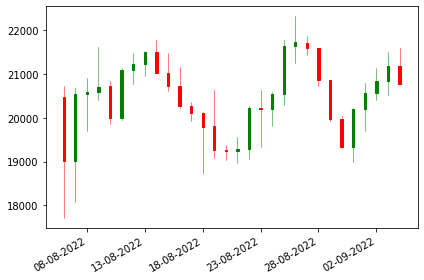

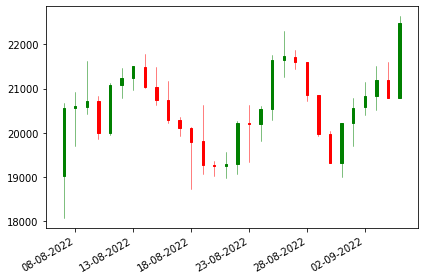

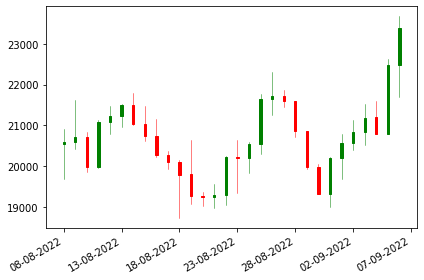

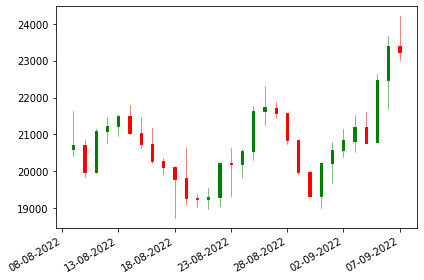

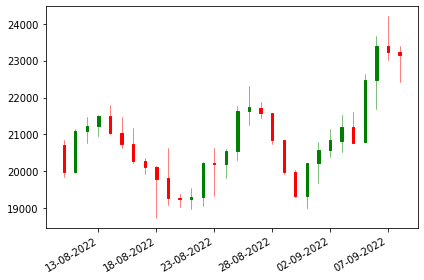

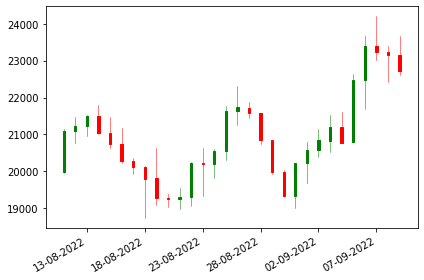

In [78]:
how_many_future_candles = 1
how_many_past_candles = 1
each_row_past = 30


global which_future_or_past
which_future_or_past = None
if how_many_future_candles > how_many_past_candles:
    which_future_or_past = how_many_future_candles
else:
    which_future_or_past = how_many_past_candles
folder_name = start(how_many_future_candles,how_many_past_candles,each_row_past)
len(os.listdir(f"/content/extracted/{folder_name}"))

In [79]:
you_want_to_save_into_rar_right = True
file_name = "123456"
if you_want_to_save_into_rar_right:
   shutil.make_archive(folder_name,"zip",f"/content/extracted/{folder_name}/")
else:
   folder_name = file_name
   shutil.unpack_archive(f"/content/{folder_name}.zip",f"/content/extracted/{folder_name}")
label = []
data  = []
files = os.listdir(f"/content/extracted/{folder_name}/")
for i, image_name in enumerate(files):
  if image_name.split(".")[1] == "png":
    image = cv2.imread(f"/content/extracted/{folder_name}"+"/"+image_name,0)
    dim = (110, 80)
    resized = cv2.resize(image, dim)
    data.append(np.array(resized))
    sugg = image_name.split("_")[1].split(".")[0]
    label.append(int(sugg))
data = np.array(data)
data = data / 255
print(data.shape)
xTrain , xTest , yTrain , yTest = train_test_split(data,label,test_size=0.2,random_state=99)
data = None
label = None
print(f"xTrain : {len(xTrain)} \\ xTest : {len(xTest)}")
nytrain = []
nytest = []
yn = 0
nn = 0
for i in yTrain:
  if i == 1:
    nytrain.append([1,0])
    yn += 1
  else:
    nytrain.append([0,1])
    nn += 1
for i in yTest:
  if i == 1:
    nytest.append([1,0])
    yn += 1
  else:
    nytest.append([0,1])
    nn += 1
yTrain = np.array(nytrain)
yTest = np.array(nytest)
print(f"yn: {yn} nn: {nn}")

(114, 80, 110)
xTrain : 91 \ xTest : 23
yn: 49 nn: 65


In [80]:
model = Sequential()

model.add(Conv2D(128,    (3, 3),activation="relu", input_shape=(xTrain.shape[1], xTrain.shape[2],1)))
model.add(Conv2D(128,    (2, 2),activation="relu",))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128,    (3, 3),activation="relu",))
model.add(Conv2D(128,    (2, 2),activation="relu",))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64,    (2, 2),activation="relu",))
model.add(Conv2D(32,    (3, 3),activation="relu",))
model.add(Flatten())
model.add(Dense(750,activation="relu"))
model.add(Dense(750,activation="relu"))
model.add(Dense(750,activation="relu"))
model.add(Dense(750,activation="relu"))
model.add(Dense(2,activation="sigmoid"))

adamax = tf.keras.optimizers.Adamax(
    learning_rate=0.001)
model.compile(loss='categorical_crossentropy',
              optimizer=adamax,
              metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 78, 108, 128)      1280      
                                                                 
 conv2d_1 (Conv2D)           (None, 77, 107, 128)      65664     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 38, 53, 128)      0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 36, 51, 128)       147584    
                                                                 
 conv2d_3 (Conv2D)           (None, 35, 50, 128)       65664     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 17, 25, 128)      0         
 2D)                                                    

In [ ]:
filepath = "/content/checkpoints/{epoch:02d}-{val_accuracy:.2f}.h5"
model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
    filepath=filepath,
    save_weights_only=False,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

#model.fit(xTrain,yTrain,batch_size=64,epochs=30,validation_data=(xTest,yTest), callbacks=model_checkpoint_callback)
model.fit(xTrain,yTrain,batch_size=16,epochs=20,validation_data=(xTest,yTest))


Epoch 1/20
6/6 [==============================] - 13s 2s/step - loss: 0.6918 - accuracy: 0.5275 - val_loss: 0.6929 - val_accuracy: 0.5217
Epoch 2/20
6/6 [==============================] - 11s 2s/step - loss: 0.6910 - accuracy: 0.5824 - val_loss: 0.6922 - val_accuracy: 0.5217
Epoch 3/20
6/6 [==============================] - 11s 2s/step - loss: 0.6873 - accuracy: 0.5824 - val_loss: 0.6945 - val_accuracy: 0.5217
Epoch 4/20
6/6 [==============================] - 11s 2s/step - loss: 0.6836 - accuracy: 0.5824 - val_loss: 0.7001 - val_accuracy: 0.5217
Epoch 5/20
6/6 [==============================] - 11s 2s/step - loss: 0.6838 - accuracy: 0.5824 - val_loss: 0.6984 - val_accuracy: 0.5217
Epoch 6/20
6/6 [==============================] - 11s 2s/step - loss: 0.6819 - accuracy: 0.5824 - val_loss: 0.6950 - val_accuracy: 0.5217
Epoch 7/20
6/6 [==============================] - 11s 2s/step - loss: 0.6801 - accuracy: 0.5824 - val_loss: 0.6985 - val_accuracy: 0.5217
Epoch 8/20


In [ ]:
model.save("first_model.h5")

In [ ]:
yf.download("btc-usd",period="max",interval="1d")


In [ ]:
data = yf.download("btc-usd",period="max",interval="1d")
data = np.array(data)
data = data.astype(float)

In [ ]:

rows = data[-31:-1, :]
df = pd.DataFrame(rows, columns=["Open", "High", "Low", "Close","Adj Close","Volume"])
df.index.name = "Date"
df.index = pd.to_datetime(df.index)
fig, _a = mpl.plot(df, type="candle", style="yahoo", axisoff=True,
                            returnfig=True, tight_layout=True,figsize =(1.5,1.5))
fig.savefig("btctobepred.png")

In [ ]:
image = cv2.imread("/content/btctobepred.png",0)
dim = (110, 80)
resized = cv2.resize(image, dim)
data = np.array(resized)

In [ ]:
data.shape

In [ ]:
model.predict([[data.reshape(1,80,110)]])

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
yf.download("btc-usd",period="max",interval="1d")

In [ ]:
data = yf.download("btc-usd",period="max",interval="1d")

In [ ]:
data = np.array(data)

In [ ]:
data[-11:-1,:]